In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

# Kfold stuff
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, log_loss, make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing

# For optimizing hyper parameters
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from bayes_opt import BayesianOptimization

# For selecting features
import shap

# For creating loading bars and measuring time
from tqdm.notebook import tqdm
import time

# Statistical distributions
from scipy import stats

# Reading the data

We start by opening the files and loading them into a Numpy array

In [2]:
import h5py
import pandas

def load_data(name):
    with h5py.File(f'{name}.h5', 'r') as f:
        return pd.DataFrame(f[name][:])

train = load_data('train')
test  = load_data('test')

Then we can verify the shape

In [3]:
print (f'Shape of training data set: {train.shape}')
print (f'Shape of test data set: {test.shape}')

Shape of training data set: (162500, 166)
Shape of test data set: (160651, 164)


As expected, the test set contains 2 columns less: `Truth` and `p_truth_E`.
    
Then we copy the variable list from the course website <https://www.nbi.dk/~petersen/Teaching/ML2020/SmallProject/VariableList.html>

In [4]:
all_variables = ['actualInteractionsPerCrossing', 'averageInteractionsPerCrossing', 'correctedActualMu', 'correctedAverageMu', 'correctedScaledActualMu', 'correctedScaledAverageMu', 'NvtxReco', 'p_nTracks', 'p_pt_track', 'p_eta', 'p_phi', 'p_charge', 'p_qOverP', 'p_z0', 'p_d0', 'p_sigmad0', 'p_d0Sig', 'p_EptRatio', 'p_dPOverP', 'p_z0theta', 'p_etaCluster', 'p_phiCluster', 'p_eCluster', 'p_rawEtaCluster', 'p_rawPhiCluster', 'p_rawECluster', 'p_eClusterLr0', 'p_eClusterLr1', 'p_eClusterLr2', 'p_eClusterLr3', 'p_etaClusterLr1', 'p_etaClusterLr2', 'p_phiClusterLr2', 'p_eAccCluster', 'p_f0Cluster', 'p_etaCalo', 'p_phiCalo', 'p_eTileGap3Cluster', 'p_cellIndexCluster', 'p_phiModCalo', 'p_etaModCalo', 'p_dPhiTH3', 'p_R12', 'p_fTG3', 'p_weta2', 'p_Reta', 'p_Rphi', 'p_Eratio', 'p_f1', 'p_f3', 'p_Rhad', 'p_Rhad1', 'p_deltaEta1', 'p_deltaPhiRescaled2', 'p_TRTPID', 'p_TRTTrackOccupancy', 'p_numberOfInnermostPixelHits', 'p_numberOfPixelHits', 'p_numberOfSCTHits', 'p_numberOfTRTHits', 'p_numberOfTRTXenonHits', 'p_chi2', 'p_ndof', 'p_SharedMuonTrack', 'p_E7x7_Lr2', 'p_E7x7_Lr3', 'p_E_Lr0_HiG', 'p_E_Lr0_LowG', 'p_E_Lr0_MedG', 'p_E_Lr1_HiG', 'p_E_Lr1_LowG', 'p_E_Lr1_MedG', 'p_E_Lr2_HiG', 'p_E_Lr2_LowG', 'p_E_Lr2_MedG', 'p_E_Lr3_HiG', 'p_E_Lr3_LowG', 'p_E_Lr3_MedG', 'p_ambiguityType', 'p_asy1', 'p_author', 'p_barys1', 'p_core57cellsEnergyCorrection', 'p_deltaEta0', 'p_deltaEta2', 'p_deltaEta3', 'p_deltaPhi0', 'p_deltaPhi1', 'p_deltaPhi2', 'p_deltaPhi3', 'p_deltaPhiFromLastMeasurement', 'p_deltaPhiRescaled0', 'p_deltaPhiRescaled1', 'p_deltaPhiRescaled3', 'p_e1152', 'p_e132', 'p_e235', 'p_e255', 'p_e2ts1', 'p_ecore', 'p_emins1', 'p_etconeCorrBitset', 'p_ethad', 'p_ethad1', 'p_f1core', 'p_f3core', 'p_maxEcell_energy', 'p_maxEcell_gain', 'p_maxEcell_time', 'p_maxEcell_x', 'p_maxEcell_y', 'p_maxEcell_z', 'p_nCells_Lr0_HiG', 'p_nCells_Lr0_LowG', 'p_nCells_Lr0_MedG', 'p_nCells_Lr1_HiG', 'p_nCells_Lr1_LowG', 'p_nCells_Lr1_MedG', 'p_nCells_Lr2_HiG', 'p_nCells_Lr2_LowG', 'p_nCells_Lr2_MedG', 'p_nCells_Lr3_HiG', 'p_nCells_Lr3_LowG', 'p_nCells_Lr3_MedG', 'p_pos', 'p_pos7', 'p_poscs1', 'p_poscs2', 'p_ptconeCorrBitset', 'p_ptconecoreTrackPtrCorrection', 'p_r33over37allcalo', 'p_topoetconeCorrBitset', 'p_topoetconecoreConeEnergyCorrection', 'p_topoetconecoreConeSCEnergyCorrection', 'p_weta1', 'p_widths1', 'p_widths2', 'p_wtots1', 'p_e233', 'p_e237', 'p_e277', 'p_e2tsts1', 'p_ehad1', 'p_emaxs1', 'p_fracs1', 'p_DeltaE', 'p_E3x5_Lr0', 'p_E3x5_Lr1', 'p_E3x5_Lr2', 'p_E3x5_Lr3', 'p_E5x7_Lr0', 'p_E5x7_Lr1', 'p_E5x7_Lr2', 'p_E5x7_Lr3', 'p_E7x11_Lr0', 'p_E7x11_Lr1', 'p_E7x11_Lr2', 'p_E7x11_Lr3', 'p_E7x7_Lr0', 'p_E7x7_Lr1' ]

Finally, we divide the training data into data (`X`) and labels (`y`)

In [5]:
# Train sample
X_unscaled = train[all_variables]
y_truth = train['Truth']
y_energy = train['p_truth_E']

# Test sample
X_test_unscaled = test[all_variables]

print (f'Shape of X: {X_unscaled.shape}')
print (f'Shape of y_truth: {y_truth.shape}')
print (f'Shape of y_energy: {y_energy.shape}')
print (f'Shape of X_test: {X_test_unscaled.shape}')

Shape of X: (162500, 160)
Shape of y_truth: (162500,)
Shape of y_energy: (162500,)
Shape of X_test: (160651, 160)


# Scale the Data

We have 160 variables all with different distributions and different ranges of values, we therefor need to scale the data before we use it to train, so that one parameter will not dominate due to large values or something like that.

There are many way to scale the data each method being better for a certain distribution of data or special features of data or the model that we want to run. Since we have so many different variables I will use what I consider the most simple: RobustScaler. It is possible that we should scale each column differently but that seems like overkill, so lets stick with this. We create our scala by fitting to the train data, we then also scale our test data, that we will use in the end.

In [7]:
#X = preprocessing.normalize(X_unscaled, norm='l2', axis=0)
scaler = preprocessing.RobustScaler().fit(X_unscaled)
X = scaler.transform(X_unscaled)

# Scale test sample
X_test = scaler.transform(X_test_unscaled)

# Select the 25 most important physical parameters
There are 160 variables for each event, which is way to much. We need to pick at most the 25 most important ones, that means the ones that makes the largest cut in the tree based model, i.e. classifies the most events with one cut. There are multiple ways to do this. XGBOOST has a built in feauture_importance that gives a score for how important the physical parameters are (based on the effect of a permutation of a columns value on the loss function). 

Another way to do this is with SHAP which is based on game theory. We will also try this, but this is more computationally expensive.

In [8]:
# Split data into train set and validation set - make LARGE val size, so we can quickly estimate best parameters
X_train, X_val, y_train, y_val = train_test_split(X, y_truth, test_size=0.33, random_state=1)

In [9]:
# Train model
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=1, 
                          use_label_encoder=False)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

Text(0.5, 0, 'Xgboost Feature Importance')

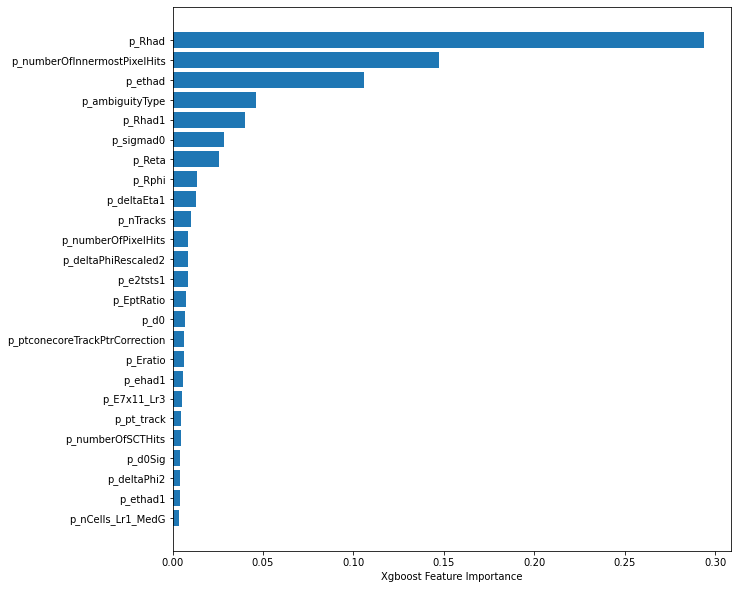

In [10]:
# Plot feature importances
fig, ax1 = plt.subplots(figsize=(10,10))
sorted_idx = model.feature_importances_.argsort()
ax1.barh(np.array(all_variables)[sorted_idx][-25:], model.feature_importances_[sorted_idx][-25:])
ax1.set_xlabel("Xgboost Feature Importance")

Here I have shown the 25 most important features, we do however need to make a decision of how many paramters we will use. To do this we will train the model with respectively 10, 15, 20 and 25 parameters to see how much the accuracy increases as a function of computer time or something like this, and then we can make a choice of how long we want our models to run and thus how many parameters to chose. But first let's do it with SHAP.

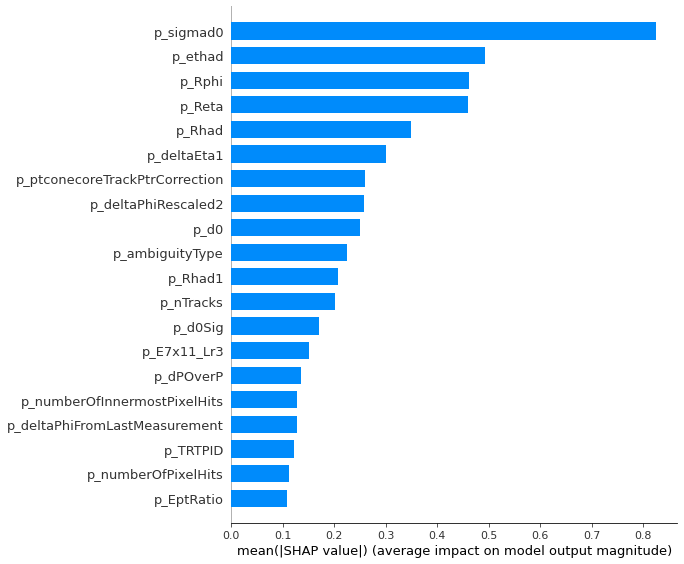

In [11]:
# Run shap to get the most important parameters
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Plot them
shap.summary_plot(shap_values, X_val, plot_type="bar", feature_names=all_variables)

In [12]:
# Get mean shap values
mean_shap = np.mean(abs(shap_values), axis=0)
sort_idx = np.argsort(mean_shap)
sort_shap = mean_shap[sort_idx][-25:][::-1]
sort_shap_var = np.array(all_variables)[sort_idx][-25:][::-1]

# Display the values
shap_val25 = pd.Series( (sort_shap), index=sort_shap_var  )
display(shap_val25)

p_sigmad0                         0.825379
p_ethad                           0.493707
p_Rphi                            0.462573
p_Reta                            0.460439
p_Rhad                            0.349799
p_deltaEta1                       0.300351
p_ptconecoreTrackPtrCorrection    0.260168
p_deltaPhiRescaled2               0.258604
p_d0                              0.249752
p_ambiguityType                   0.225140
p_Rhad1                           0.207607
p_nTracks                         0.202244
p_d0Sig                           0.170295
p_E7x11_Lr3                       0.150962
p_dPOverP                         0.135867
p_numberOfInnermostPixelHits      0.128075
p_deltaPhiFromLastMeasurement     0.127225
p_TRTPID                          0.121290
p_numberOfPixelHits               0.112756
p_EptRatio                        0.109301
p_numberOfSCTHits                 0.102261
p_r33over37allcalo                0.086893
p_deltaPhi2                       0.084039
p_Eratio   

Now let's choose how many parameters we will include in the model. There are different things to consider here: 
how well the model performs, here measured with the Loss MAE, and computing time. Lets look into this.

In [13]:
# Set how many parameters we will test out
n_params = [5,10,12,15,20,25]

# Empty arrays to store values
accuracy_arr = []
computer_time = []

fpr_arr = []
tpr_arr = []
auc_arr = []

# Make X a pandas dataframe so we can use variable names to slice
df_X = pd.DataFrame((X), columns=all_variables )

# Loop over number of parameters used in a model
for n in tqdm(n_params):
    
    # Make a new X (input data containing 20 best parameters)
    X_temp = df_X[sort_shap_var[:n]]
    
    # Split test data and train data
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_truth, test_size=0.33, random_state=1)
    
    # Train model and time it
    model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=1, 
                              use_label_encoder=False)
    t0 = time.process_time()
    model.fit(X_train, y_train)
    t = time.process_time() - t0
    computer_time.append(t)
    
    # Get accuracy
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_arr.append(accuracy)
    
    # Get fpr, tpr and auc score
    predictions = model.predict_proba(X_val) # find prediction that a particle belongs to each class ndarray
    predictions = pd.DataFrame(predictions)
    predictions.columns = ['not_electron', 'electron']
    fpr, tpr, _ = roc_curve(y_val, predictions['electron'])
    fpr_arr.append(fpr)
    tpr_arr.append(tpr)
    auc_score = auc(fpr, tpr)
    auc_arr.append(auc_score)

  0%|          | 0/6 [00:00<?, ?it/s]

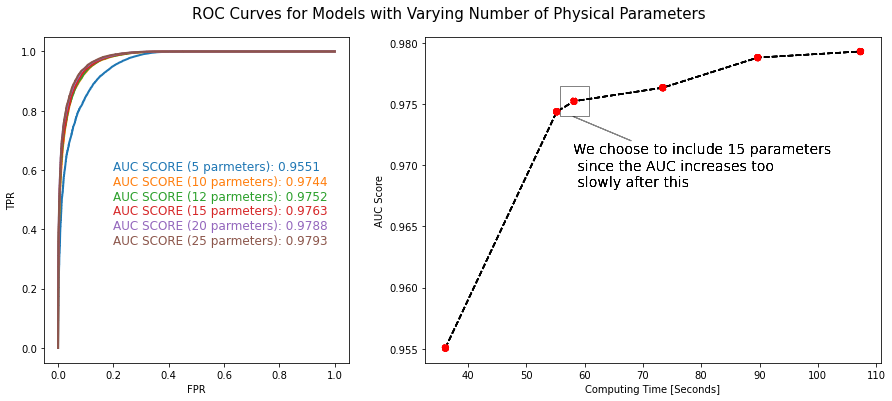

In [19]:
# Plot ROC Curves and AUC vs. Computing times
fig, ax = plt.subplots(ncols=2, figsize=(15,6), gridspec_kw={'width_ratios':(1,1.5)})

for i in range(len(n_params)):
    
    # Plot ROC curve ----------------------------------------------------------------------------------------
    ax[0].plot(fpr_arr[i], tpr_arr[i], label=f'{n_params[i]} parameters', linewidth=2)
    ax[0].set_xlabel('FPR')
    ax[0].set_ylabel('TPR')
    
    # Mark auc scores
    ax[0].text(0.2, 0.6-i/20, f'AUC SCORE ({n_params[i]} parmeters): {auc_arr[i]:.4f}', color=f'C{i}', fontsize=12) 
    
    # Plot AUC vs. Computing time ---------------------------------------------------------------------------
    ax[1].plot(computer_time, auc_arr, color='k', linestyle='dashed', zorder=1)
    ax[1].scatter(computer_time, auc_arr, color='r', linestyle='dashed', zorder=2, s=40)
    ax[1].set_ylabel('AUC Score')
    ax[1].set_xlabel('Computing Time [Seconds]')
    
    # Mark the number of parameters we use
    circle = plt.Rectangle((55.7, 0.974), 5, 0.0025, color='k', alpha=0.1, fill=False)
    ax[1].add_patch(circle)
    line = plt.arrow(58, 0.974, 10, -0.002, width=0.000000001, color='k', alpha=0.05)
    ax[1].add_patch(line)
    text = 'We choose to include 15 parameters \n since the AUC increases too \n slowly after this'
    ax[1].text(58, 0.9683, text, fontsize=14, weight='light') 
    
fig.suptitle('ROC Curves for Models with Varying Number of Physical Parameters', fontsize=15, y=0.95)
plt.show()

# Random Search - Finding Hyper parameters with K-fold cross validation

Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.

It is a popular method because it is simple to understand and because it generally results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train/test split

The general procedure is as follows:

- Shuffle the dataset randomly.
- Split the dataset into k groups
- For each unique group:
- Take the group as a hold out or test data set
- Take the remaining groups as a training data set
- Fit a model on the training set and evaluate it on the test set
- Retain the evaluation score and discard the model
- Summarize the skill of the model using the sample of model evaluation scores

We use k=5. Ten might be better but it takes too long.

First we split the data into train set and a test set. We will then split the train set through k-fold cross validation. We can use these training sets to find the right hyperparameters, and then we can use that on the entire training set, to make the best model. We will use a Random Search (Bayesian Optimization takes 3+ hours, I tried), from sklearn, which has the k fold cross validation implemented.
<img src="kfold.png">

In [20]:
# Prepare data (with 15 parameters), df_X is already scaled
X = df_X[sort_shap_var[:15]]
    
# Split into test data and train data (get small test_size)
X_train, X_val, y_train, y_val = train_test_split(X, y_truth, test_size=0.9, random_state=1)

In [21]:
# Small train sample to find hyper parameters
X_train.shape

(16250, 15)

We make a Random Search tuning the depth of the decision trees and the number of trees. The depth of the tree quickly consumes memor when increased, and my computer is almost retiring, so lets stick to evaluating between 1 and 10. As for the number of trees I can't seem to find the typical range to be in.

To make the proces faster we start with a high learning rate, to roughly determine the value. We can later lower it and look specifically in that range to find the optimal hyperparameters.

But first, we need to determine our scoring metric, that will evaluate which parameter combinations do well. As is evident from the cell below, our dataset is unbalanced and we will therefor use the 'balanced' accuracy as our scoring parameter instead of the regular "accuracy". The difference is explained in this post: https://statisticaloddsandends.wordpress.com/2020/01/23/what-is-balanced-accuracy/

In [22]:
print('No. Electrons:', np.sum(y_truth))
print('No. of non-electrons', len(y_truth)-np.sum(y_truth))
print('We are working with a UNBALANCED dataset')

No. Electrons: 121495
No. of non-electrons 41005
We are working with a UNBALANCED dataset


In [23]:
### Initial Random Search ###

# Specify parameters and distributions to sample from
parameters_RandomSearch = {'max_depth': stats.randint(1,10), 
                           'n_estimators': stats.randint(1, 400)}

# Chose number of iterations and number of folds
n_iter_search = 10
k = 5

# Decide model configurations
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=1,
                         learning_rate=0.3, use_label_encoder=False)

RandomSearch = RandomizedSearchCV(model, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=k, 
                                  return_train_score=True,
                                  random_state=1,
                                  scoring = 'balanced_accuracy')

# Fit the random search instance
RandomSearch.fit(X_train, y_train);

In [24]:
# Get results
RandomSearch_results = pd.DataFrame(RandomSearch.cv_results_)                 
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.3f}")

RandomSearch_results.head(5)

Random Search: 	Best parameters:  {'max_depth': 7, 'n_estimators': 282} , Best scores: 0.895


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,5.248808,0.241730,0.022500,0.003060,6,236,"{'max_depth': 6, 'n_estimators': 236}",0.894321,0.888067,0.901097,...,0.892325,0.004996,6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,6.965907,0.067095,0.025111,0.001058,9,256,"{'max_depth': 9, 'n_estimators': 256}",0.897250,0.888103,0.897991,...,0.893505,0.004961,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,6.834931,0.057438,0.023163,0.000174,6,336,"{'max_depth': 6, 'n_estimators': 336}",0.896626,0.888091,0.904827,...,0.893751,0.006301,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,0.636119,0.031759,0.015697,0.001431,1,145,"{'max_depth': 1, 'n_estimators': 145}",0.880985,0.876435,0.887543,...,0.881944,0.003633,10,0.888916,0.889429,0.887600,0.889203,0.893252,0.889680,0.001895
4,0.555011,0.012617,0.014997,0.000901,2,72,"{'max_depth': 2, 'n_estimators': 72}",0.887023,0.875834,0.890703,...,0.884706,0.005719,9,0.899918,0.901933,0.899119,0.901257,0.903557,0.901157,0.001553


In [25]:
### New random search close to the best point ###

# Specify parameters and distributions to sample from (center around the best values from previous search)
parameters_RandomSearch2 = {'max_depth': stats.randint(4,9), 
                           'n_estimators': stats.randint(200,400) }

# Chose number of iterations and number of folds
n_iter_search = 10
k = 5

# Decide model configurations (lower learning rate for more precise result)
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=1,
                         learning_rate=0.3, use_label_encoder=False)

RandomSearch2 = RandomizedSearchCV(model, 
                                   param_distributions=parameters_RandomSearch2, 
                                   n_iter=n_iter_search, 
                                   cv=k, 
                                   return_train_score=True,
                                   random_state=1,
                                   scoring = 'balanced_accuracy')

# Fit the random search instance
RandomSearch2.fit(X_train, y_train);

In [26]:
# Get results
RandomSearch2_results = pd.DataFrame(RandomSearch2.cv_results_)                 
print("Random Search: \tBest parameters: ", RandomSearch2.best_params_, f", Best scores: {RandomSearch2.best_score_:.3f}")

RandomSearch2_results.head(5)

Random Search: 	Best parameters:  {'max_depth': 7, 'n_estimators': 333} , Best scores: 0.895


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,7.892836,0.206615,0.026858,0.003096,7,340,"{'max_depth': 7, 'n_estimators': 340}",0.899519,0.887910,0.899034,...,0.894666,0.004546,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,4.841630,0.067385,0.019721,0.000141,4,337,"{'max_depth': 4, 'n_estimators': 337}",0.904128,0.882940,0.898227,...,0.893484,0.007193,4,0.998441,0.997973,0.997817,0.997193,0.997973,0.997879,0.000402
2,7.521853,0.071421,0.024963,0.000293,7,333,"{'max_depth': 7, 'n_estimators': 333}",0.899519,0.889363,0.899238,...,0.895287,0.003836,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,4.913376,0.032158,0.019815,0.000138,4,344,"{'max_depth': 4, 'n_estimators': 344}",0.903084,0.881271,0.898636,...,0.893232,0.007439,5,0.998441,0.998441,0.997973,0.997193,0.998284,0.998066,0.000469
4,4.775380,0.039251,0.020045,0.000732,5,271,"{'max_depth': 5, 'n_estimators': 271}",0.900371,0.887863,0.894078,...,0.890396,0.006282,9,1.000000,0.999844,0.999844,1.000000,0.999844,0.999906,0.000076


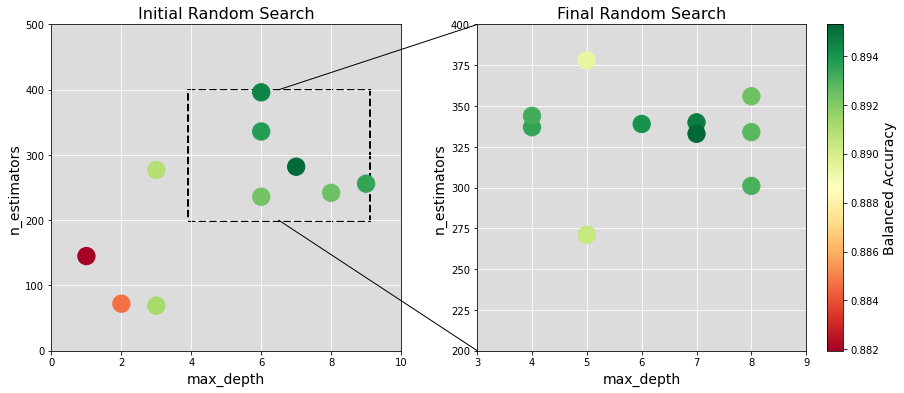

In [27]:
# Lets try to plot it with colors in a 2d parameter space ----------------------------------

# Create figure
fig, ax = plt.subplots(ncols=2, figsize=(15,6), gridspec_kw={'wspace':0.2, 'width_ratios':(1.7,2)})

# Get parameters
x1 = RandomSearch_results['param_max_depth']
x2 = RandomSearch_results['param_n_estimators']
color = RandomSearch_results['mean_test_score']

x1_2 = RandomSearch2_results['param_max_depth']
x2_2 = RandomSearch2_results['param_n_estimators']
color2 = RandomSearch2_results['mean_test_score']

mini, maxi = np.min(np.concatenate((color,color2))), np.max(np.concatenate((color,color2))) #color ranges

# Plot initial random search
ax[0].scatter(x1, x2, s=300, c = color, cmap='RdYlGn', zorder=2, vmin=mini, vmax=maxi)
ax[0].set_facecolor('gainsboro')
ax[0].grid(color='w', zorder=0)
ax[0].set_xlabel('max_depth', fontsize=14)
ax[0].set_ylabel('n_estimators', fontsize=14)
ax[0].set_title('Initial Random Search', fontsize=16)
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,500)

# Plot final search
im2 = ax[1].scatter(x1_2, x2_2, s=300, c = color2, cmap='RdYlGn', zorder=2, vmin=mini, vmax=maxi)
ax[1].set_facecolor('gainsboro')
ax[1].grid(color='w', zorder=0)
ax[1].set_xlabel('max_depth', fontsize=14)
ax[1].set_ylabel('n_estimators', fontsize=14)
ax[1].set_title('Final Random Search', fontsize=16)
ax[1].set_xlim(3,9)
ax[1].set_ylim(200,400)

# Shared colorbar
cbar = fig.colorbar(im2, ax=ax[1])
cbar.set_label('Balanced Accuracy', fontsize=14, x=1.7)

# Mark the zoom in plot ------------------------
# Square
rect = patches.Rectangle((3.9,199.1), 5.2, 200.2, linewidth=2, edgecolor='k', facecolor='none', linestyle='dashed')
ax[0].add_patch(rect)
# Lines
line1 = patches.ConnectionPatch(xyA=(6.5,200), xyB=(3,200), coordsA=ax[0].transData, coordsB=ax[1].transData)
fig.add_artist(line1)
line2 = patches.ConnectionPatch(xyA=(6.5,400), xyB=(3,400), coordsA=ax[0].transData, coordsB=ax[1].transData)
fig.add_artist(line2)

plt.show()

# Bayesian Optimization - Finding Hyper parameters

We can also do Bayesian Optimization to find the hyper parameters that leads to the highest accuracy. This is also based on 5 fold cross validation, but is, instead of random, a driven search.

In [28]:
# Do 5-fold cross validation to optimize hyperparameters
def XGB_CrossValidation(max_depth, n_estimators, data, targets):
    """Decision Tree cross validation.
       Fits a Decision Tree with the given parameters to the target 
       given data, calculated a CV balanced accuracy score (for unbalanced data sets) and returns the mean.
       The goal is to find combinations of max_depth, min_samples_leaf 
       that maximize the accuracy
       
       Inspired from Heavis function
    """
    estimator = xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.3,
                            max_depth=max_depth, eval_metric='logloss', n_estimators=n_estimators,
                            seed=1, use_label_encoder=False)
    
    cval = cross_val_score(estimator, data, targets, scoring='balanced_accuracy', cv=5)
    
    return cval.mean()

In [29]:
def optimize_XGB(data, targets, pars, init_points=4, n_iter=5):
    """Apply Bayesian Optimization to XGBOOST parameters."""
    
    def crossval_wrapper(max_depth, n_estimators):
        """Wrapper of Decision Tree cross validation. 
           Notice how we ensure max_depth, n_estimators 
           are casted to integer before we pass them along.
        """
        return XGB_CrossValidation(max_depth=int(max_depth), 
                                            n_estimators=int(n_estimators), 
                                            data=data, 
                                            targets=targets)

    optimizer = BayesianOptimization(f=crossval_wrapper, 
                                     pbounds=pars, 
                                     random_state=1, 
                                     verbose=2)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

    return optimizer

In [30]:
parameters_BayesianOptimization = {"max_depth": (1, 10), 
                                   "n_estimators": (1, 400)}

BayesianOptimization_object = optimize_XGB(X_train, 
                                           y_train, 
                                           parameters_BayesianOptimization, 
                                           init_points=6, n_iter=9)
print(BayesianOptimization_object.max)

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
|  1        |  0.8934   |  4.753    |  288.4    |
|  2        |  0.8807   |  1.001    |  121.6    |
|  3        |  0.8807   |  2.321    |  37.84    |
|  4        |  0.8878   |  2.676    |  138.9    |
|  5        |  0.8929   |  4.571    |  216.0    |
|  6        |  0.8939   |  4.773    |  274.4    |
|  7        |  0.894    |  4.313    |  275.7    |
|  8        |  0.8855   |  1.104    |  388.5    |
|  9        |  0.8921   |  10.0     |  178.7    |
|  10       |  0.8856   |  1.0      |  332.5    |
|  11       |  0.884    |  1.04     |  243.4    |
|  12       |  0.8836   |  1.0      |  197.4    |
|  13       |  0.8929   |  10.0     |  163.5    |
|  14       |  0.8934   |  9.885    |  303.9    |
|  15       |  0.8759   |  9.268    |  1.291    |
{'target': 0.8939802998788032, 'params': {'max_depth': 4.313221961654325, 'n_estimators': 275.66231273031656}}


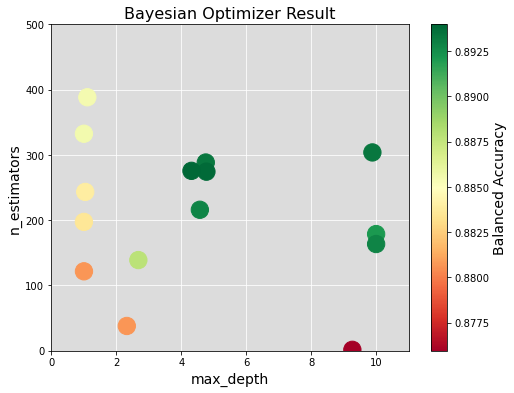

In [31]:
# Plot it

# Create figure
fig, ax = plt.subplots(figsize=(8,6))

# Get parameters
targets = []
max_dep = []
n_esti = []

for i in BayesianOptimization_object.res:
    
    targets.append(i['target'])
    max_dep.append(i['params']['max_depth'])
    n_esti.append(i['params']['n_estimators'])

# Plot initial random search
im = ax.scatter(max_dep, n_esti, s=300, c = targets, cmap='RdYlGn', zorder=2)
ax.set_facecolor('gainsboro')
ax.grid(color='w', zorder=0)
ax.set_xlabel('max_depth', fontsize=14)
ax.set_ylabel('n_estimators', fontsize=14)
ax.set_title('Bayesian Optimizer Result', fontsize=16)
ax.set_xlim(0,11)
ax.set_ylim(0,500)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Balanced Accuracy', fontsize=14)

plt.show()

# Bayesian Optimization of Cross Entropy function

In [35]:
def XGB_LogLoss_CV(max_depth, n_estimators, data, targets):
    """Decision Tree cross validation.
       Fits a Decision Tree with the given parameters to the target 
       given data, calculated a CV balanced accuracy score (for unbalanced data sets) and returns the mean.
       The goal is to find combinations of max_depth, min_samples_leaf 
       that maximize the accuracy
       
       Inspired from Heavis function
    """
    estimator = xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.3,
                            max_depth=max_depth, eval_metric='logloss', n_estimators=n_estimators,
                            random_state=1, use_label_encoder=False)
    
    cross_entro = make_scorer(log_loss, eps=1e-10, greater_is_better=False) #negative output -> maximize
    cval = cross_val_score(estimator, data, targets, scoring=cross_entro, cv=5)
    #cval = cross_val_score(estimator, data, targets, scoring='neg_log_loss', cv=5) #negative so is maximized
    
    return cval.mean()

In [36]:
def optimize_XGB_LogLoss(data, targets, pars, init_points=4, n_iter=5):
    """Apply Bayesian Optimization to XGBOOST parameters."""
    
    def crossval_wrapper(max_depth, n_estimators):
        """Wrapper of Decision Tree cross validation. 
           Notice how we ensure max_depth, n_estimators 
           are casted to integer before we pass them along.
        """
        return XGB_LogLoss_CV(max_depth=int(max_depth), 
                                            n_estimators=int(n_estimators), 
                                            data=data, 
                                            targets=targets)

    optimizer = BayesianOptimization(f=crossval_wrapper, 
                                     pbounds=pars, 
                                     random_state=1, 
                                     verbose=2)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

    return optimizer

In [37]:
parameters_BayesianOptimization = {"max_depth": (1, 10), 
                                   "n_estimators": (1, 400)}

BayesianOptimization_object_LogLoss = optimize_XGB_LogLoss(X_train, 
                                                   y_train, 
                                                   parameters_BayesianOptimization, 
                                                   init_points=6, n_iter=9)
print(BayesianOptimization_object_LogLoss.max)

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
|  1        | -1.562    |  4.753    |  288.4    |
|  2        | -1.62     |  1.001    |  121.6    |
|  3        | -1.607    |  2.321    |  37.84    |
|  4        | -1.566    |  2.676    |  138.9    |
|  5        | -1.56     |  4.571    |  216.0    |
|  6        | -1.55     |  4.773    |  274.4    |
|  7        | -1.55     |  4.313    |  275.7    |
|  8        | -1.571    |  4.735    |  162.3    |
|  9        | -1.601    |  1.0      |  246.4    |
|  10       | -1.559    |  8.433    |  197.1    |
|  11       | -1.526    |  9.808    |  319.2    |
|  12       | -1.525    |  9.906    |  332.8    |
|  13       | -1.576    |  1.0      |  351.6    |
|  14       | -1.588    |  1.0      |  325.9    |
|  15       | -1.52     |  9.695    |  326.5    |
{'target': -1.5204146454072447, 'params': {'max_depth': 9.695179996084999, 'n_estimators': 326.4586782027844}}


# Make a final model

The best balanced accuracy we have obtained so far according to the balanced accuracy metric was from the initial random search, we will thus use that configuration to train our model on the test data. 

First we split our data into training data and validation data (the final test data is available still for predictions)

In [38]:
# Split into train data and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y_truth, test_size=0.2, random_state=1)

In [39]:
# Chose parameters from Random Search
max_depth_RS = RandomSearch.best_params_['max_depth']
n_estimators_RS = RandomSearch.best_params_['n_estimators']

# Set up model
model_RS = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=1,
                              use_label_encoder=False, max_depth=max_depth_RS, n_estimators=n_estimators_RS)

# Train model on train set
model_RS.fit(X_train, y_train)

# Calculate balanced accuracy score
y_pred_RS = model_RS.predict(X_val)
accuracy_RS = balanced_accuracy_score(y_val, y_pred_RS)
print('Balanced accuracy:', accuracy_RS)

# Get predictions
predictions_RS = model_RS.predict_proba(X_val)
predictions_RS = pd.DataFrame(predictions_RS, columns=['not_electron', 'electron'])

# Get fpr and tpr to produce roc_curve
fpr_RS, tpr_RS, _ = roc_curve(y_val, predictions_RS['electron'])
auc_score_RS = auc(fpr_RS, tpr_RS)

Balanced accuracy: 0.9084100869338676


In [45]:
# Chose parameters from Bayesian optimization according to cross entropy metric
max_depth_BO = int(BayesianOptimization_object_LogLoss.max['params']['max_depth'])
n_estimators_BO = int(BayesianOptimization_object_LogLoss.max['params']['n_estimators'])

# Set up model
model_BO = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=1,
                              use_label_encoder=False, max_depth=max_depth_BO, n_estimators=n_estimators_BO)

# Train model on train set
model_BO.fit(X_train, y_train)

# Calculate balanced accuracy score
y_pred_BO = model_BO.predict(X_val)
accuracy_BO = balanced_accuracy_score(y_val, y_pred_BO)
print('Balanced accuracy:', accuracy_BO)

# Get predictions
predictions_BO = model_BO.predict_proba(X_val)
predictions_BO = pd.DataFrame(predictions_BO, columns=['not_electron', 'electron'])

# Get fpr and tpr to produce roc_curve
fpr_BO, tpr_BO, _ = roc_curve(y_val, predictions_BO['electron'])
auc_score_BO = auc(fpr_BO, tpr_BO)

Balanced accuracy: 0.9080680444623961


In [81]:
# Evaluate Loss Function on the models
cross_entro = make_scorer(log_loss, eps=1e-10, greater_is_better=False)
loss_RS = cross_val_score(model_RS, X_val, y_val, scoring=cross_entro, cv=5)
loss_BO = cross_val_score(model_BO, X_val, y_val, scoring=cross_entro, cv=5)

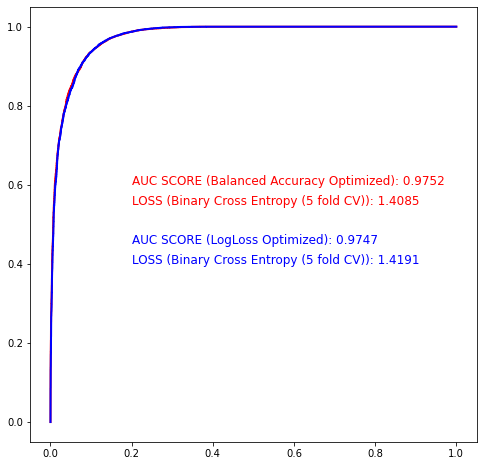

In [86]:
# Plot ROC curve
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(fpr_RS, tpr_RS, color='r', linewidth=2)
ax.plot(fpr_BO, tpr_BO, color='b', linewidth=2)

# Mark auc scores
ax.text(0.2, 0.6, f'AUC SCORE (Balanced Accuracy Optimized): {auc_score_RS:.4f}', color='r', fontsize=12)
ax.text(0.2, 0.55, f'LOSS (Binary Cross Entropy (5 fold CV)): {-loss_RS.mean():.4f}', color='r', fontsize=12)

ax.text(0.2, 0.45, f'AUC SCORE (LogLoss Optimized): {auc_score_BO:.4f}', color='b', fontsize=12) 
ax.text(0.2, 0.4, f'LOSS (Binary Cross Entropy (5 fold CV)): {-loss_BO.mean():.4f}', color='b', fontsize=12)

plt.show()

The ROC curves for the two are quite similar, but it seems the first one (Balanced Accuracy optimised) performs better even though the other one was optimized to perform well on the loss function we evaluate it with. Nonetheless let's stick with the first, red, model.

# Make predictions on test data and produce csv file

In [87]:
# Extract the physical parameters we have chosen in the test set -------------------------

# Make X_test a pandas dataframe so we can use variable names to slice
df_X_test = pd.DataFrame((X_test), columns=all_variables )
    
# Make a new X (input data containing 20 best parameters)
X_test = df_X_test[sort_shap_var[:15]]

# Make probability predictions between 0 and 1
# columns are 'not_electron' and 'electron' below: it doesnt matter which one we chose
final_predictions = model_RS.predict_proba(X_test)

# Extract electrons column
final_predictions = pd.DataFrame(final_predictions[:,0], columns=['probability prediction'])

should it be [:,1]?

In [88]:
# Make csv file with predictions
file_name = 'Classification_KimiKreilgaard_XGBoostClassifier.txt'
final_predictions.to_csv('Solutions/'+file_name, sep=',', header=None, index=True, mode='w')

In [94]:
# Make csv file with parameters used
file_name = 'Classification_KimiKreilgaard_XGBoostClassifier_VariableList.txt'

outfile = open('Solutions/'+file_name, 'w')

for var in sort_shap_var[:15]:
    outfile.write(var+'\n')